In [7]:
! pip install GPUtil ninja torch===1.7.1+cu110 torchvision===0.8.2+cu110 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

import numpy as np
from PIL import Image
from numba import cuda
from tensorflow import keras
import matplotlib.pyplot as plt
import glob, json, os, h5py, pickle, torch
from GPUtil import showUtilization as gpu_usage

M, N, SIZE = 4, 3, 140
BACKUP = '/kaggle/input/deepshoes-backup'
CLASS, GENE = f'{BACKUP}/classification.h5', f'{BACKUP}/generation.pkl'
GAN, OUTPUT = 'stylegan2-ada-pytorch', '/kaggle/working/output'

Looking in links: https://download.pytorch.org/whl/torch_stable.html


Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 1.12 MiB | 8.08 MiB/s, done.
Resolving deltas: 100% (57/57), done.
Loading networks from "/kaggle/input/deepshoes-backup/generation.pkl"...
Generating image for seed 61 (0/12) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Generating image for seed 1449 (1/12) ...
Generating image for seed 105 (2/12) ...
Generating image for seed 1314 (3/12) ...
Generating image for seed 1415 (4/12) ...
Generating image for seed 1074 (5/12) ...
Generating image for seed 1027 (6/12) ...
Generating image for seed 1066 (7/12) ...
Generating image for seed 1992 (8/12) ...
Generating image for seed 1898 (9/12) ...
Generating image for seed 1029 (10/12) ...
Generating image for seed 641 (11/12) ...


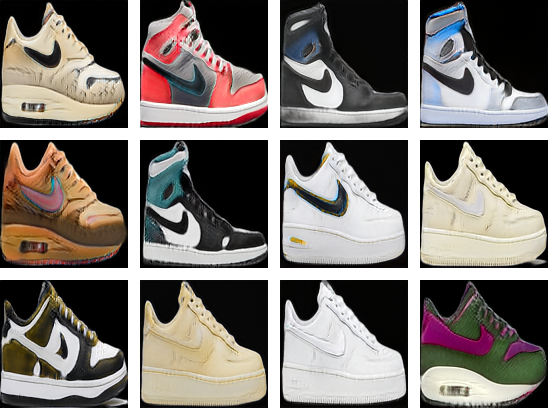

In [8]:
seeds = ",".join(str(i) for i in np.random.choice(range(1, 2000), M*N, False))
for _ in range(5):
    torch.cuda.empty_cache(); cuda.select_device(0); cuda.close(); cuda.select_device(0)
        
! rm -rf $OUTPUT $GAN
! git clone https://github.com/NVlabs/$GAN
! python $GAN/generate.py --network $GENE --outdir $OUTPUT --seeds $seeds --trunc 1

images = [Image.open(path) for path in glob.glob(f'{OUTPUT}/*')]

generated = Image.new('RGB', (SIZE*M, SIZE*N), color = 'white')
for i, img in enumerate(images):
    generated.paste(img, (SIZE*(i//N), SIZE*(i%N)))
generated

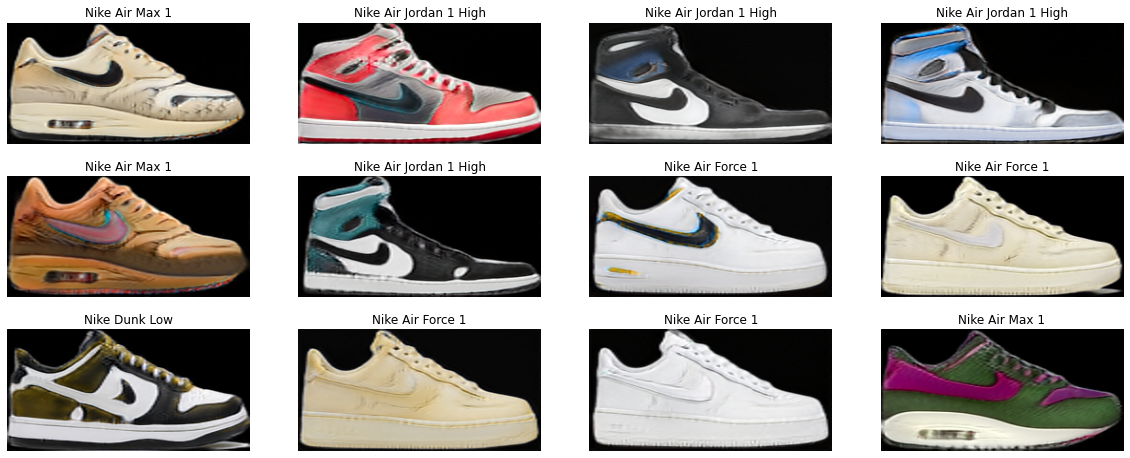

In [27]:
classification = h5py.File(CLASS, 'r')
predictor = keras.models.load_model(classification).predict
meta = json.loads(classification.attrs['metadata'])
pairs_, width_, height_ = meta['pairs'], meta['width'], meta['height']

_, axes = plt.subplots(ncols=M, nrows=N, figsize=(20,8))
for ind, img in enumerate(images):
    image = np.array(img.resize((width_, height_)))
    probas = predictor(np.array([image]), verbose=False)[0]
    predicted = pairs_[np.argmax(probas)]
    axis = axes[ind%N, ind//N]
    axis.set_title(predicted); axis.imshow(image); axis.axis("off")
plt.show()